# GRASS GIS 7 Python 脚本库介绍

[GRASS GIS 7](http://grass.osgeo.org/grass7/) Python脚本库提供了一些函数，可以实现在脚本中调用GRASS GIS作为子进程执行操作。

最常用的函数有以下四个：
* __`run_command`__: 当调用不需要返回信息的矢量和栅格操作模块时使用
* __`read_command`__: 当对文本输出信息感兴趣时使用
* __`parse_command`__: 当调用文本输出形式为 键=值对 的模块时使用
* __`write_command`__: 当调用需要输入文本信息或文件的模块时使用

此外，该库还为常用的模块提供了一些封装函数。

## 尝试调用GRASS GIS模块

首先导入GRASS GIS Python脚本库：

In [1]:
import grass.script as gscript

在运行任何的GRASS栅格模块之前，都需要设置计算范围，使用函数[g.region](http://grass.osgeo.org/grass70/manuals/g.region.html)。在本例中，设定计算范围和分辨率与栅格图层`elevation`相同。

In [7]:
gscript.run_command('g.region', raster='elevation')

0


`run_command()` 是最常使用的函数，在这个步骤中，使用均值平滑法([r.neighbors](http://grass.osgeo.org/grass70/manuals/r.neighbors.html)) ，对`elevation`进行平滑。



In [10]:
gscript.read_command('r.neighbors', input='elevation', output='elev_smoothed', method='average', flags='c')

''

## 程序交互过程的细节解释

使用GUI时，我们可以实时查看地图。但是在脚本中，我们很少渲染地图。在IPython Notebook中，我们可以显示地图，为此，我们使用这些笔记本随附的自定义Python模块`render`中的函数`view()`。（此功能将来可能会成为IASS的GRASS GIS Python API的一部分。）

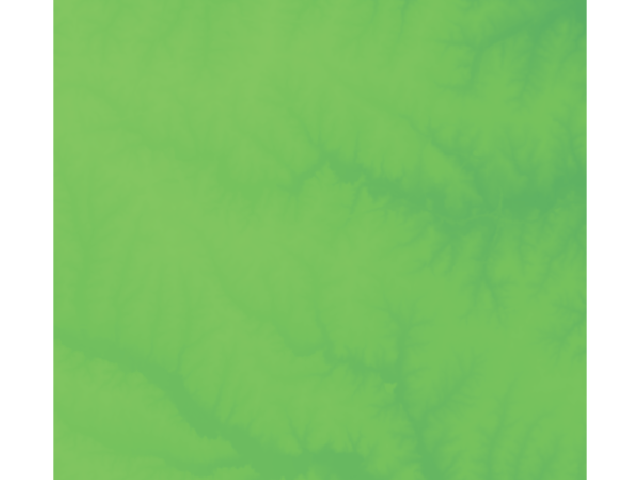

In [12]:
from render import view
view(rasters=['elev_smoothed'])


为了简化示例的多次运行，我们设置了环境变量`GRASS_OVERWRITE`，这样就可以直接覆盖先前运行的显示结果，而无需进行覆盖检查。

In [20]:
import os
os.environ['GRASS_OVERWRITE'] = '1'

当发生不可恢复的错误时（由于不正确的参数使用或其他问题），GRASS GIS函数通常会打印错误消息并结束程序执行（通过调用`exit（）`函数）。 但是，当在诸如IPython的交互式环境中工作时，可以使用`set_raise_on_error（）`函数来更改其行为。以下调用将导致GRASS GIS Python函数引发异常，而不是调用`exit（）`。

In [21]:
gscript.set_raise_on_error(True)

False

## 用文本输入或输出调用GRASS GIS模块

模块的文本输出可以使用`read_command（）`函数捕获。

In [23]:
print(gscript.read_command('g.region', flags='p'))#输出此时规定的region的信息

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      10
ewres:      10
rows:       1350
cols:       1500
cells:      2025000



In [25]:
print(gscript.read_command('r.univar', map='elev_smoothed', flags='g'))#栅格数据的简单统计

n=2025000
null_cells=0
cells=2025000
min=56.4
max=156
range=99.6
mean=110.259593777782
mean_of_abs=110.259593777782
stddev=20.2603181004566
variance=410.480489531689
coeff_var=18.3751067877952
sum=223275677.400008



某些模块可以通过设置flags为 __`g`__ 表示按照键值对格式输出结果。`parse_command()`函数能够自动转换输出结果为dictionary类型。
在下面的例子中，通过调用[g.proj](http://grass.osgeo.org/grass70/manuals/g.proj.html)显示地点的投影参数。


In [26]:
gscript.parse_command('g.proj', flags='g')

{u'a': u'6378137.0',
 u'datum': u'nad83',
 u'epsg': u'3358',
 u'es': u'0.006694380022900787',
 u'lat_0': u'33.75',
 u'lat_1': u'36.16666666666666',
 u'lat_2': u'34.33333333333334',
 u'lon_0': u'-79',
 u'meters': u'1',
 u'name': u'Lambert Conformal Conic',
 u'no_defs': u'defined',
 u'proj': u'lcc',
 u'unit': u'Meter',
 u'units': u'Meters',
 u'x_0': u'609601.22',
 u'y_0': u'0'}

为了进行比较，下面是相同的示例，但是使用了`read_command（）`函数，返回值为字符串形式

In [27]:
print(gscript.read_command('g.proj', flags='g'))

name=Lambert Conformal Conic
proj=lcc
datum=nad83
a=6378137.0
es=0.006694380022900787
lat_1=36.16666666666666
lat_2=34.33333333333334
lat_0=33.75
lon_0=-79
x_0=609601.22
y_0=0
no_defs=defined
epsg=3358
unit=Meter
units=Meters
meters=1




某些模块要求提供文本或文件作为标准输入，使用`write_command（）`函数，可以方便地将字符串传递给模块。在这里，使用[v.in.ascii](http://grass.osgeo.org/grass70/manuals/v.in.ascii.html)创建具有一个点的新矢量,请注意，__*stdin*__ 参数未用作模块参数，但是其内容作为标准输入传递给子流程。



In [28]:
gscript.write_command('v.in.ascii', input='-', stdin='%s|%s' % (635818.8, 221342.4), output='view_point')

0

## 方便调用的封装函数

为了对使用次数频繁的操作进行简化，一些模块具有单独的封装函数

为了获取矢量图层信息，[v.info](http://grass.osgeo.org/grass70/manuals/v.info.html)函数被封装为:

In [30]:
gscript.vector_info('view_point')#获取矢量图层信息

{u'areas': 0,
 u'bottom': 0.0,
 u'boundaries': 0,
 u'centroids': 0,
 u'comment': u'',
 u'creator': u'geo',
 u'database': u'/home/geo/geo_future/grassdata',
 u'digitization_threshold': u'0.000000',
 u'east': 635818.8,
 u'format': u'native',
 u'islands': 0,
 u'level': 2,
 u'lines': 0,
 u'location': u'futures_ncspm',
 u'map3d': False,
 u'mapset': u'FUTURES_triangle',
 u'name': u'view_point',
 u'nodes': 0,
 u'north': 221342.4,
 u'num_dblinks': 0,
 u'organization': u'',
 u'points': 1,
 u'primitives': 1,
 u'projection': u'Lambert Conformal Conic',
 u'scale': u'1:1',
 u'source_date': u'Tue May 12 00:31:13 2020',
 u'south': 221342.4,
 u'timestamp': u'none',
 u'title': u'',
 u'top': 0.0,
 u'west': 635818.8}

同样，可以检索栅格图层历史记录([r.support](http://grass.osgeo.org/grass70/manuals/r.support.html))以及栅格图层的信息([r.info](http://grass.osgeo.org/grass70/manuals/r.info.html))，或者对栅格信息进行查询检索([r.what](http://grass.osgeo.org/grass70/manuals/r.what.html))

In [31]:
gscript.raster_what('elevation', [[635818.8, 221342.4], [635710, 221330]])

[{'elevation': {'color': '160:108:056', 'label': '', 'value': '139.9174'}},
 {'elevation': {'color': '182:122:061', 'label': '', 'value': '137.2558'}}]

另外一个例子为，[r.mapcalc](http://grass.osgeo.org/grass70/manuals/r.mapcalc.html)函数的封装，该函数常被用于栅格的代数以及逻辑运算中。

In [33]:
gscript.mapcalc("elev_strip = if(elevation > 100 && elevation < 125, elevation, null())")
print(gscript.read_command('r.univar', map='elev_strip', flags='g'))

n=775367
null_cells=1249633
cells=2025000
min=100.000015258789
max=124.999977111816
range=24.9999618530273
mean=111.69326296784
mean_of_abs=111.69326296784
stddev=7.35424773422312
variance=54.084959736326
coeff_var=6.58432526618967
sum=86603270.2275848



[g.region](http://grass.osgeo.org/grass70/manuals/g.region.html)函数的封装，是获取当前区域设置（即计算区域）的便捷方法。它返回一个dictionary字典，并将其值转换为适当的类型（`float`和`int`）。

In [34]:
region = gscript.region()
print region
# cell area in map units (in projected Locations)
region['nsres'] * region['ewres']

{u'rows': 1350, u'e': 645000.0, u'projection': 99, u'zone': 0, u'cells': 2025000, u'cols': 1500, u'n': 228500.0, u's': 215000.0, u'w': 630000.0, u'ewres': 10.0, u'nsres': 10.0}


100.0

[g.list](http://grass.osgeo.org/grass70/manuals/g.list.html)函数可以显示当前工作地点中的栅格或矢量图层名称。

In [35]:
gscript.list_grouped(['raster'])

{'FUTURES_triangle': ['counties',
  'devpressure_0_5_92',
  'dist_interchanges',
  'dist_to_protected',
  'elev_smoothed',
  'elev_smoothed1',
  'elev_strip',
  'elevation_30m',
  'forest',
  'forest_1992',
  'forest_1992_smooth',
  'forest_2011',
  'forest_smooth',
  'interchanges',
  'lakes_buff',
  'landuse_1992',
  'landuse_2001',
  'landuse_2011',
  'protected_areas',
  'road_dens',
  'roads',
  'slope',
  'urban_1992',
  'urban_2001',
  'urban_2011'],
 'PERMANENT': ['basins',
  'elevation',
  'elevation_shade',
  'geology',
  'lakes',
  'landuse']}

下面的例子是获取图层所在的mapset信息。

In [37]:
current_mapset = gscript.gisenv()['MAPSET']
gscript.list_pairs('raster', mapset=current_mapset)

[('counties', 'FUTURES_triangle'),
 ('devpressure_0_5_92', 'FUTURES_triangle'),
 ('dist_interchanges', 'FUTURES_triangle'),
 ('dist_to_protected', 'FUTURES_triangle'),
 ('elev_smoothed', 'FUTURES_triangle'),
 ('elev_smoothed1', 'FUTURES_triangle'),
 ('elev_strip', 'FUTURES_triangle'),
 ('elevation_30m', 'FUTURES_triangle'),
 ('forest', 'FUTURES_triangle'),
 ('forest_1992', 'FUTURES_triangle'),
 ('forest_1992_smooth', 'FUTURES_triangle'),
 ('forest_2011', 'FUTURES_triangle'),
 ('forest_smooth', 'FUTURES_triangle'),
 ('interchanges', 'FUTURES_triangle'),
 ('lakes_buff', 'FUTURES_triangle'),
 ('landuse_1992', 'FUTURES_triangle'),
 ('landuse_2001', 'FUTURES_triangle'),
 ('landuse_2011', 'FUTURES_triangle'),
 ('protected_areas', 'FUTURES_triangle'),
 ('road_dens', 'FUTURES_triangle'),
 ('roads', 'FUTURES_triangle'),
 ('slope', 'FUTURES_triangle'),
 ('urban_1992', 'FUTURES_triangle'),
 ('urban_2001', 'FUTURES_triangle'),
 ('urban_2011', 'FUTURES_triangle')]

## 练习

利用[r.slope.aspect](http://grass.osgeo.org/grass70/manuals/r.slope.aspect.html)函数，根据`elevation`计算坡度信息，并且统计坡度的平均值和中位数，栅格统计函数为：[r.univar](http://grass.osgeo.org/grass70/manuals/r.univar.html)

In [43]:
# Answer
gscript.run_command("r.slope.aspect",elevation="elevation",slope="slope")
print(gscript.read_command('r.univar', map='slope', flags='g'))#栅格数据统计



n=2019304
null_cells=5696
cells=2025000
min=0
max=38.6893920898438
range=38.6893920898438
mean=3.86452240667335
mean_of_abs=3.86452240667335
stddev=3.00791412221812
variance=9.04754736663921
coeff_var=77.8340453408676
sum=7803645.55388512



导出所有以 "*elev_*" 为前缀的栅格文件为GeoTiff格式[r.out.gdal](http://grass.osgeo.org/grass70/manuals/r.out.gdal.html))。不要忘记为每个地图设置当前计算区域，以匹配各个导出的栅格图层范围和分辨率，因为它们可能彼此不同。

In [44]:
# Answer
gscript.run_command('g.region', raster='elevation')

gscript.list_grouped(['raster'])#读取栅格图层列表

gscript.run_command('r.out.gdal',input='elev_smoothed',output='elev_smoothed.tif',format='GTiff')


{'FUTURES_triangle': ['counties',
  'devpressure_0_5_92',
  'dist_interchanges',
  'dist_to_protected',
  'elev_smoothed',
  'elev_smoothed1',
  'elev_strip',
  'elevation_30m',
  'forest',
  'forest_1992',
  'forest_1992_smooth',
  'forest_2011',
  'forest_smooth',
  'interchanges',
  'lakes_buff',
  'landuse_1992',
  'landuse_2001',
  'landuse_2011',
  'protected_areas',
  'road_dens',
  'roads',
  'slope',
  'urban_1992',
  'urban_2001',
  'urban_2011'],
 'PERMANENT': ['basins',
  'elevation',
  'elevation_shade',
  'geology',
  'lakes',
  'landuse']}